In [ ]:
!git clone https://github.com/openai/point-e.git

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 57 (delta 1), reused 1 (delta 1), pack-reused 50 (from 1)
Receiving objects: 100% (57/57), 1.56 MiB | 9.15 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
%cd point-e

/content/point-e


In [ ]:
!pip install -e .

Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-oh7djnu1/clip_0db843ee1967416c980b04492bd01108
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-oh7djnu1/clip_0db843ee1967416c980b04492bd01108
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=1f1f13cb9c5f22f1b5d74773972f169a726e4aa04146149c6d6bf79a85c3e41f
  Stored in directory: /tmp/pip-ephem-wheel-cache-xv5nr51m/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
  Created wheel for fire: filename=fire-0.7.0-py3-

In [ ]:
from PIL import Image
import torch
from tqdm.auto import tqdm
import numpy as np

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler, PointCloud
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base1B' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...


/content/point-e/point_e/models/download.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)


downloading upsampler checkpoint...


<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [ ]:
# Load an image to condition on.
img = Image.open('example_data/corgi.jpg')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

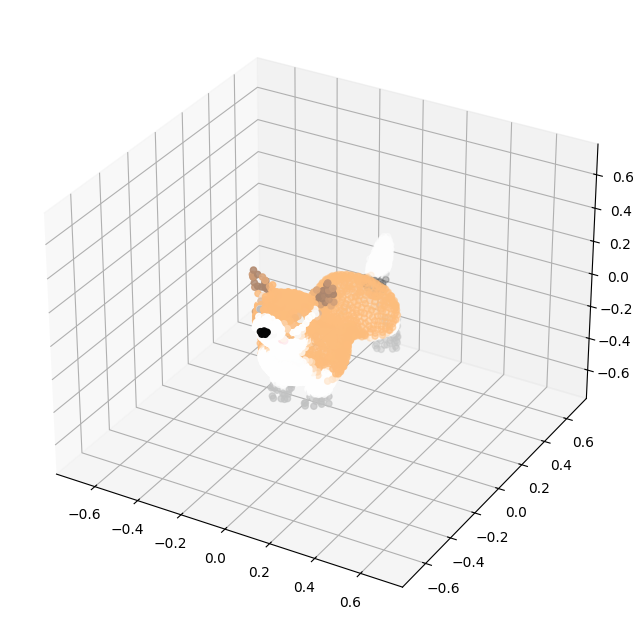

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
pc.save("corgi_1B.npz")

In [ ]:
with open("corgi_pfid.npz", "wb") as writer:
  np.savez(writer, arr_0=np.expand_dims(pc.coords, axis=0))

In [ ]:
num_recursive_steps = 2

In [ ]:
from scipy.spatial import cKDTree

def recursive_upsample(point_cloud, steps):

    for step in range(steps):
        print(f'Recursive upsampling step {step + 1}/{steps}...')

        # use PointCloud's farthest_point_sample method to downsample
        downsampled_pc = point_cloud.farthest_point_sample(num_points=1024)
        fig = plot_point_cloud(
            downsampled_pc,
            grid_size=1,
            fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75))
        )

        # ensure that 'R', 'G', 'B' channels are present
        for color in ['R', 'G', 'B']:
            if color not in downsampled_pc.channels:
                downsampled_pc.channels[color] = np.zeros(len(downsampled_pc.coords))

        # convert downsampled point cloud to tensors
        coords_tensor = torch.from_numpy(downsampled_pc.coords).unsqueeze(0).to(device).float()  # Shape: [1, 1024, 3]
        channels_tensor = {}
        for k in ['R', 'G', 'B']:
            channels_tensor[k] = torch.from_numpy(downsampled_pc.channels[k]).unsqueeze(0).to(device).float()  # Shape: [1, 1024]

        # combine coords and channels into a single tensor
        features = [coords_tensor]
        for k in ['R', 'G', 'B']:
            v = channels_tensor[k].unsqueeze(2)
            features.append(v)
        low_res_tensor = torch.cat(features, dim=2)
        low_res_tensor = low_res_tensor.permute(0, 2, 1)

        # input for the upsampler
        model_inputs = {
            'low_res': low_res_tensor,
            'images': [img],
        }

        # upsampler model
        upsampler = PointCloudSampler(
            device=device,
            models=[upsampler_model],
            diffusions=[upsampler_diffusion],
            num_points=[3072],
            aux_channels=['R', 'G', 'B'],
            guidance_scale=[0.0],
            use_karras=[False],
            karras_steps=[64],
            sigma_min=[1e-3],
            sigma_max=[1.0],
            s_churn=[0],
        )

        # generate upsampled point cloud
        samples = None
        for x in tqdm(upsampler.sample_batch_progressive(batch_size=1, model_kwargs=model_inputs)):
            samples = x

        upsampled_pc = upsampler.output_to_point_clouds(samples)[0]

        # ensure upsampled_pc has 'R', 'G', 'B' channels
        for color in ['R', 'G', 'B']:
            if color not in upsampled_pc.channels:
                upsampled_pc.channels[color] = np.zeros(len(upsampled_pc.coords))

        # assign RGB values to upsampled points based on nearest neighbors
        tree = cKDTree(downsampled_pc.coords)
        distances, indices = tree.query(upsampled_pc.coords, k=1)

        for k in ['R', 'G', 'B']:
            nearest_rgb = downsampled_pc.channels[k][indices]
            upsampled_pc.channels[k] = nearest_rgb

        # merge new points with the existing point cloud
        merged_coords = np.concatenate([point_cloud.coords, upsampled_pc.coords], axis=0)
        merged_channels = {}
        for k in ['R', 'G', 'B']:
            merged_channels[k] = np.concatenate([point_cloud.channels[k], upsampled_pc.channels[k]], axis=0)

        # update point cloud
        point_cloud = PointCloud(coords=merged_coords, channels=merged_channels)

    return point_cloud


Recursive upsampling step 1/2...


0it [00:00, ?it/s]

Recursive upsampling step 2/2...


0it [00:00, ?it/s]

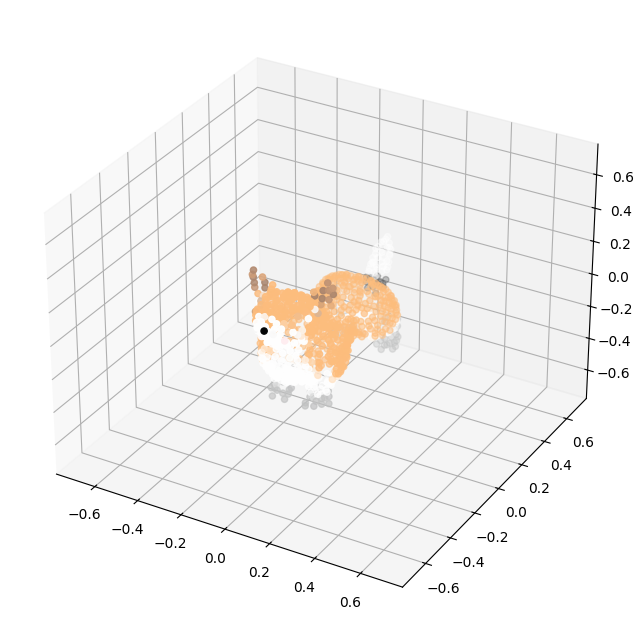

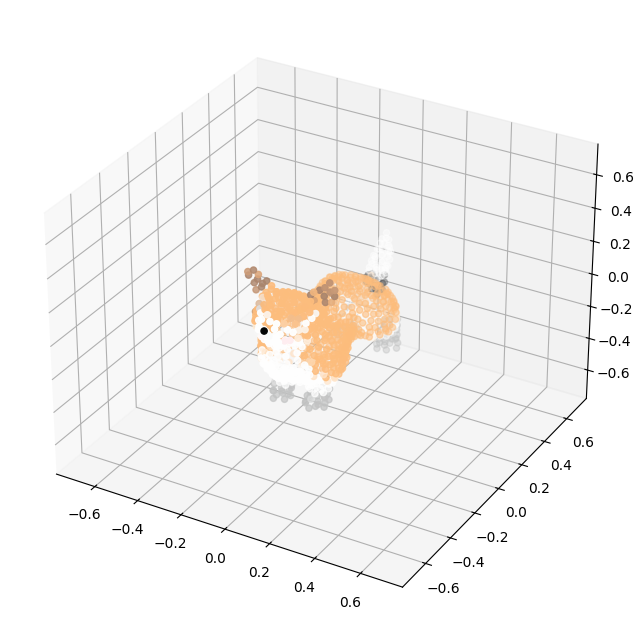

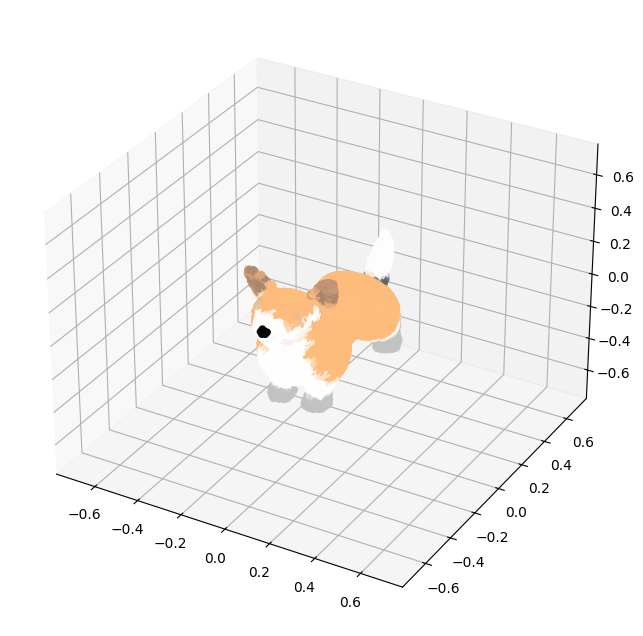

In [ ]:
final_pc = recursive_upsample(pc, num_recursive_steps)
fig = plot_point_cloud(
    final_pc,
    grid_size=1,
    fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75))
)

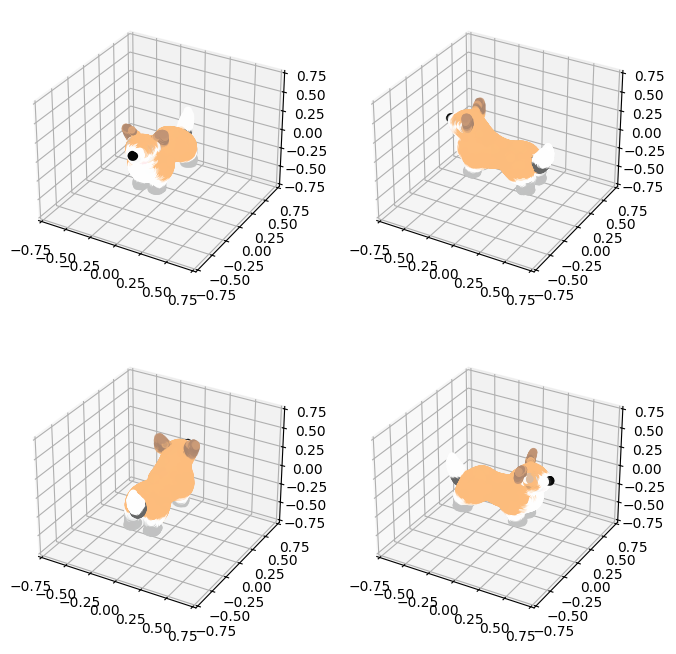

In [ ]:
fig = plot_point_cloud(
    final_pc,
    grid_size=2,
    fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75))
)

In [ ]:
final_pc.save("corgi_rec_upsampled_1B.npz")

In [ ]:
with open("corgi_rec_upsampled_pfid_1B.npz", "wb") as writer:
  np.savez(writer, arr_0=np.expand_dims(final_pc.coords, axis=0))

# Evaluations

P-FID

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base300M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...


/content/point-e/point_e/models/download.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)


downloading upsampler checkpoint...


<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [ ]:
# Load an image to condition on.
img = Image.open('example_data/corgi.jpg')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

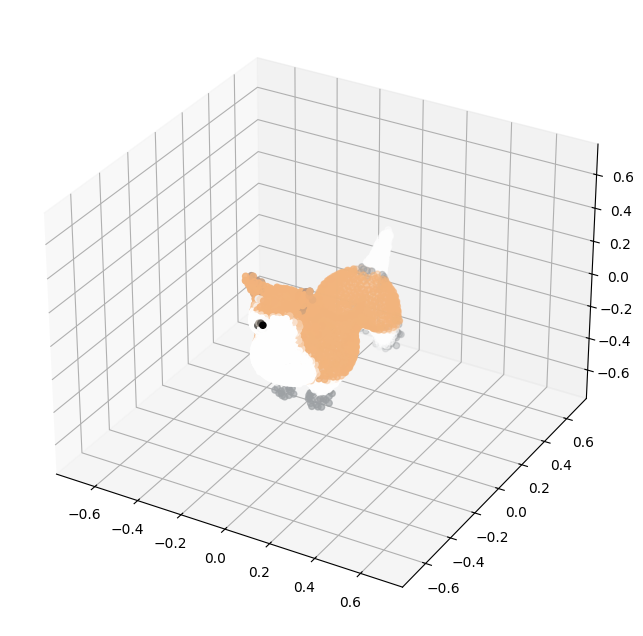

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
with open("corgi_300M_pfid.npz", "wb") as writer:
  np.savez(writer, arr_0=np.expand_dims(pc.coords, axis=0))

Recursive upsampling step 1/2...


0it [00:00, ?it/s]

Recursive upsampling step 2/2...


0it [00:00, ?it/s]

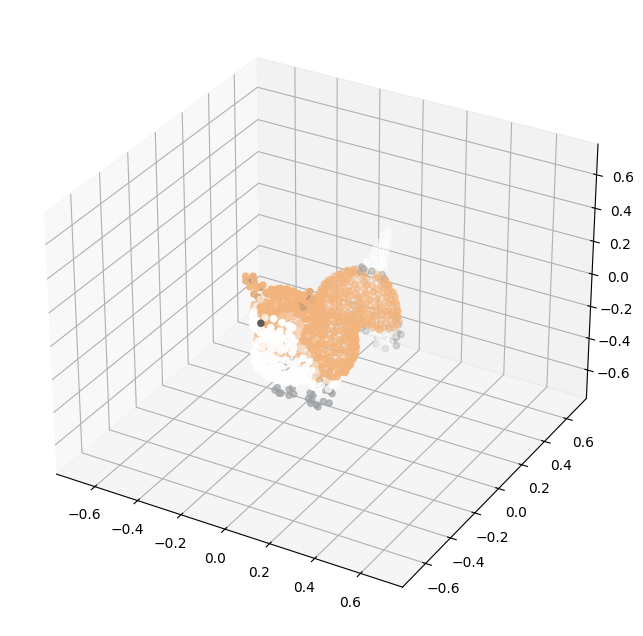

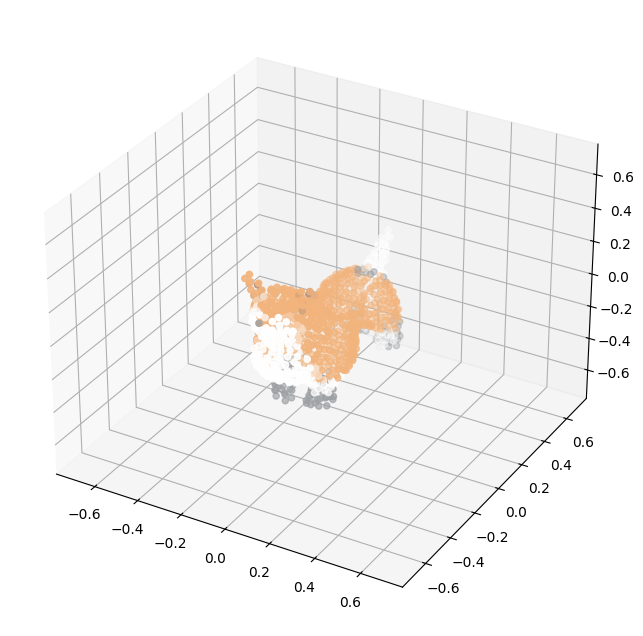

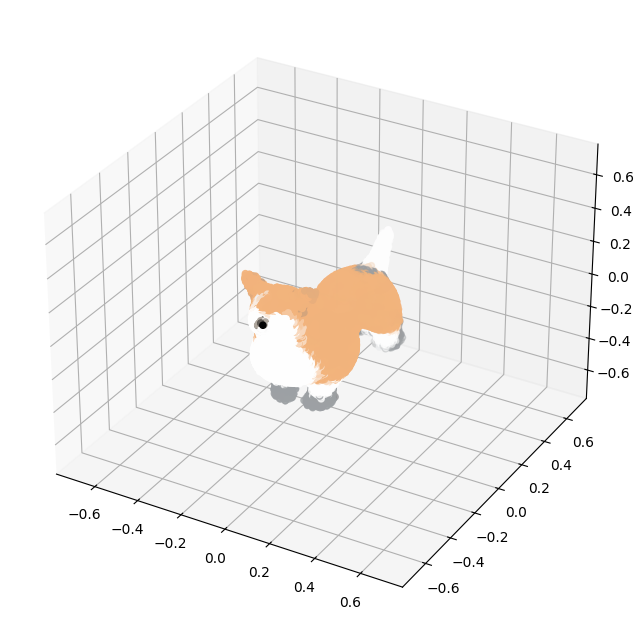

In [ ]:
final_pc = recursive_upsample(pc, num_recursive_steps)
fig = plot_point_cloud(
    final_pc,
    grid_size=1,
    fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75))
)

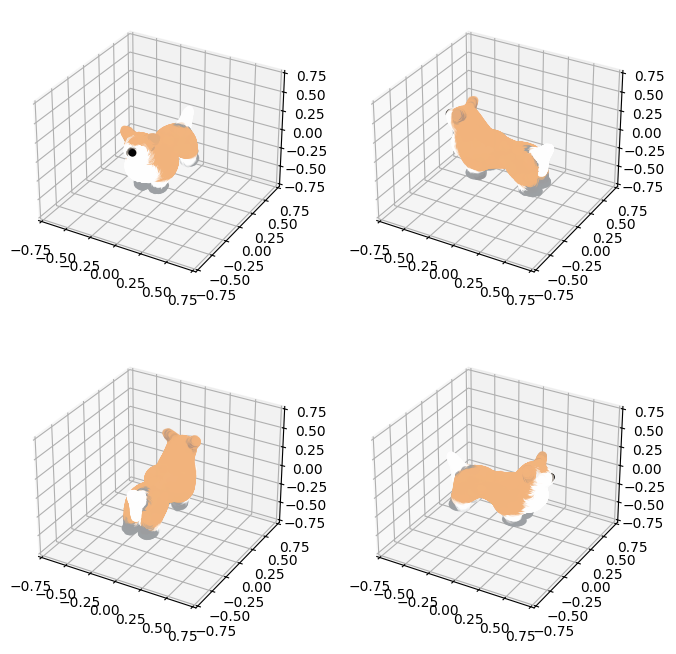

In [ ]:
fig = plot_point_cloud(
    final_pc,
    grid_size=2,
    fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75))
)

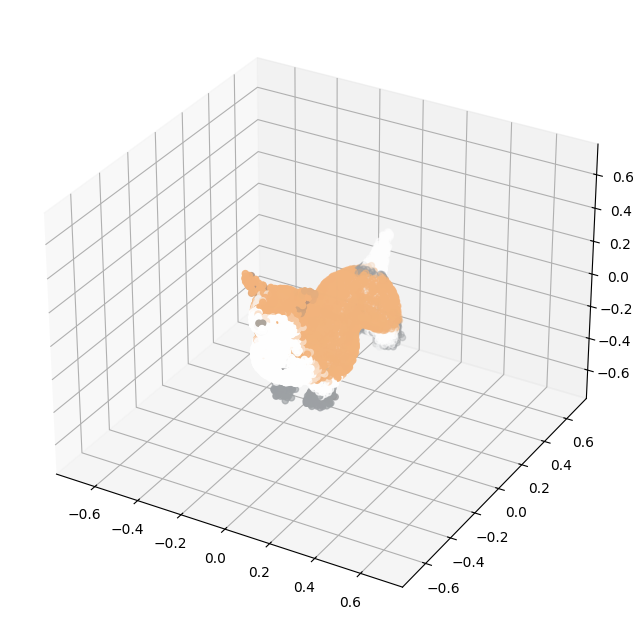

In [ ]:
downsampled_pc = final_pc.random_sample(num_points=4096)
fig = plot_point_cloud(
    downsampled_pc,
    grid_size=1,
    fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75))
)

In [ ]:
with open("corgi_300M_rec_upsampled_pfid.npz", "wb") as writer:
  np.savez(writer, arr_0=np.expand_dims(downsampled_pc.coords, axis=0))

In [ ]:
!python point_e/evals/scripts/evaluate_pfid.py corgi_300M_pfid.npz corgi_pfid.npz

creating classifier...
/content/point-e/point_e/models/download.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)
computing f

In [ ]:
!python point_e/evals/scripts/evaluate_pfid.py corgi_300M_rec_upsampled_pfid.npz corgi_pfid.npz

creating classifier...
/content/point-e/point_e/models/download.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)
computing f

In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


<All keys matched successfully>

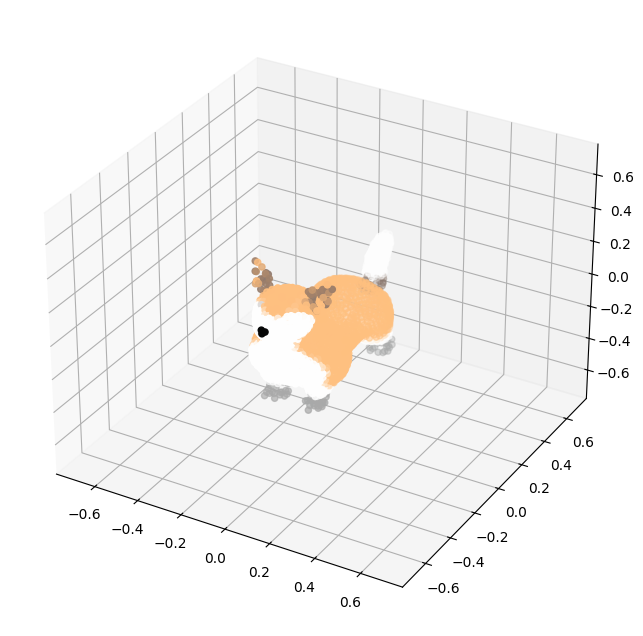

In [ ]:
# Load a point cloud we want to convert into a mesh.
pc = PointCloud.load('corgi_1B.npz')

# Plot the point cloud as a sanity check.
fig = plot_point_cloud(pc, grid_size=1)

In [ ]:
# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=128, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
# Write the mesh to a PLY file to import into some other program.
with open('corgi_1B.ply', 'wb') as f:
    mesh.write_ply(f)

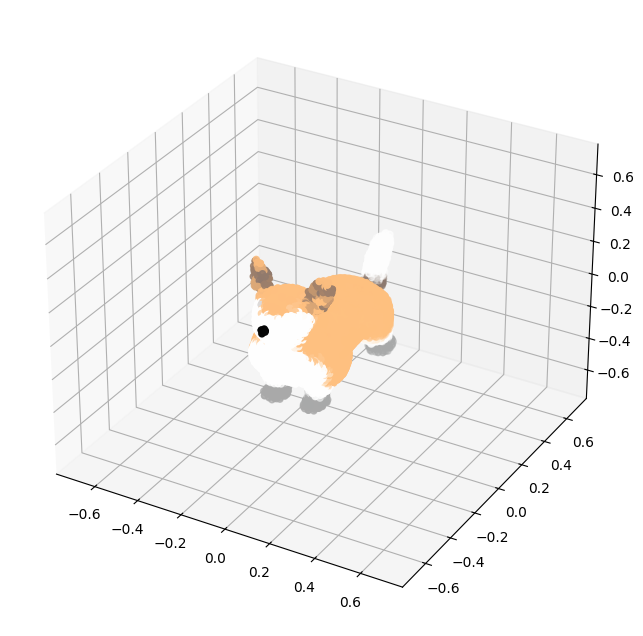

In [ ]:
# Load a point cloud we want to convert into a mesh.
final_pc = PointCloud.load('corgi_rec_upsampled_1B.npz')

# Plot the point cloud as a sanity check.
fig = plot_point_cloud(final_pc, grid_size=1)

In [ ]:
# Produce a mesh (with vertex colors)
final_mesh = marching_cubes_mesh(
    pc=final_pc,
    model=model,
    batch_size=4096,
    grid_size=128, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
# Write the mesh to a PLY file to import into some other program.
with open('corgi_rec_upsampled_1B.ply', 'wb') as f:
    final_mesh.write_ply(f)

In [ ]:
!pip install trimesh numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.4/704.4 kB 12.2 MB/s eta 0:00:00


In [ ]:
import trimesh
import numpy as np

# Function to calculate mesh quality metrics
def calculate_mesh_quality_metrics(mesh):
    # 1. Vertex and Face Count
    vertex_count = len(mesh.vertices)
    face_count = len(mesh.faces)

    # 2. Smoothness: Calculate the angle deviation between adjacent faces
    smoothness_score = np.mean(mesh.face_adjacency_angles)

    # 3. Surface Area Consistency
    face_areas = mesh.area_faces
    area_variation = np.std(face_areas) / np.mean(face_areas)

    # 5. Surface Normals Consistency
    normals = mesh.face_normals
    dot_products = np.einsum('ij,ij->i', normals[:-1], normals[1:])
    normal_consistency = np.mean(dot_products)

    return {
        "vertex_count": vertex_count,
        "face_count": face_count,
        "smoothness_score": smoothness_score,
        "area_variation": area_variation,
        "normal_consistency": normal_consistency
    }

In [ ]:
corgi = trimesh.load("corgi_1B.ply")
corgi_rec_upsampled = trimesh.load("corgi_rec_upsampled_1B.ply")

In [ ]:
corgi_metrics = calculate_mesh_quality_metrics(corgi)
corgi_rec_upsampled_metrics = calculate_mesh_quality_metrics(corgi_rec_upsampled)

print("Mesh 1 Quality Metrics:", corgi_metrics)
print("Mesh 2 Quality Metrics:", corgi_rec_upsampled_metrics)


Mesh 1 Quality Metrics: {'vertex_count': 33122, 'face_count': 66232, 'smoothness_score': 0.12182092964118733, 'area_variation': 0.6052373222444135, 'normal_consistency': 0.7929910786610459}
Mesh 2 Quality Metrics: {'vertex_count': 30490, 'face_count': 60944, 'smoothness_score': 0.08044557317441874, 'area_variation': 0.6029160882673298, 'normal_consistency': 0.8203255547514149}


## Cubestack Example

In [ ]:
# Load an image to condition on.
img = Image.open('example_data/cube_stack.jpg')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

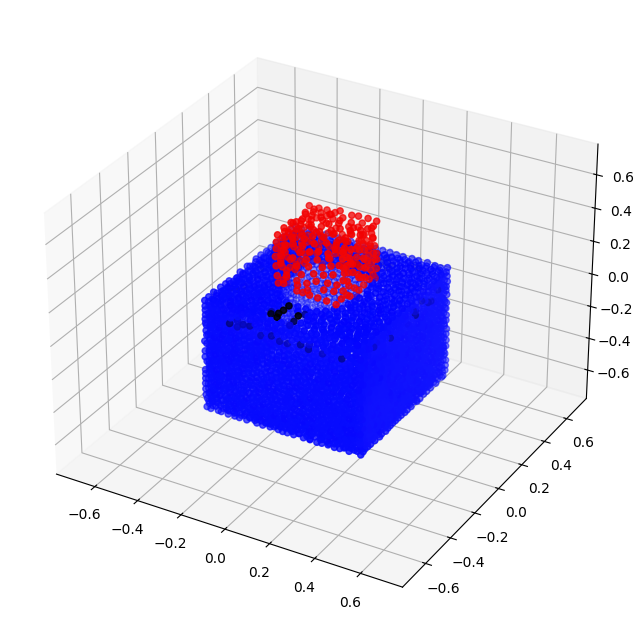

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=1, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

Recursive upsampling step 1/2...


0it [00:00, ?it/s]

Recursive upsampling step 2/2...


0it [00:00, ?it/s]

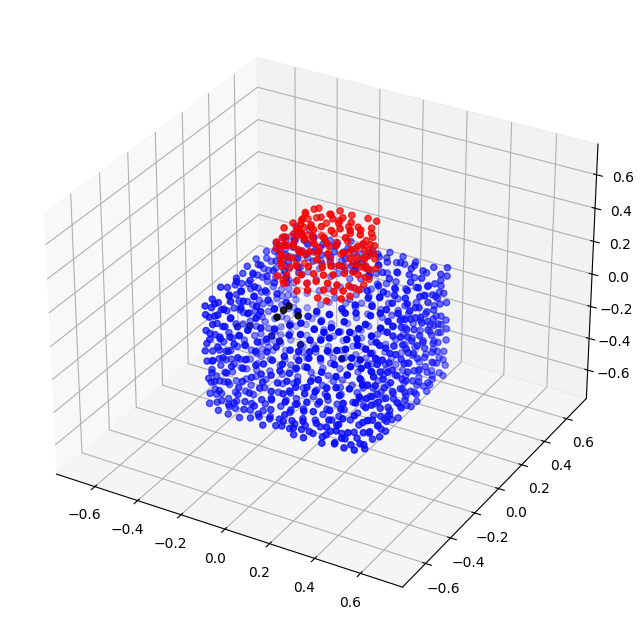

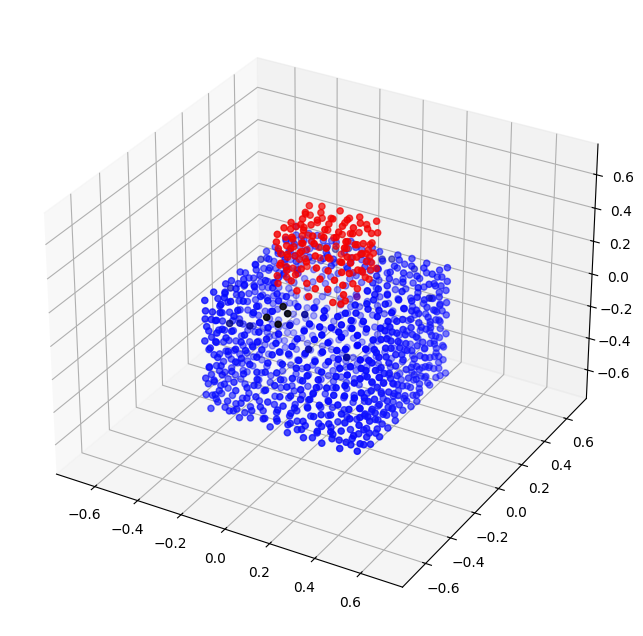

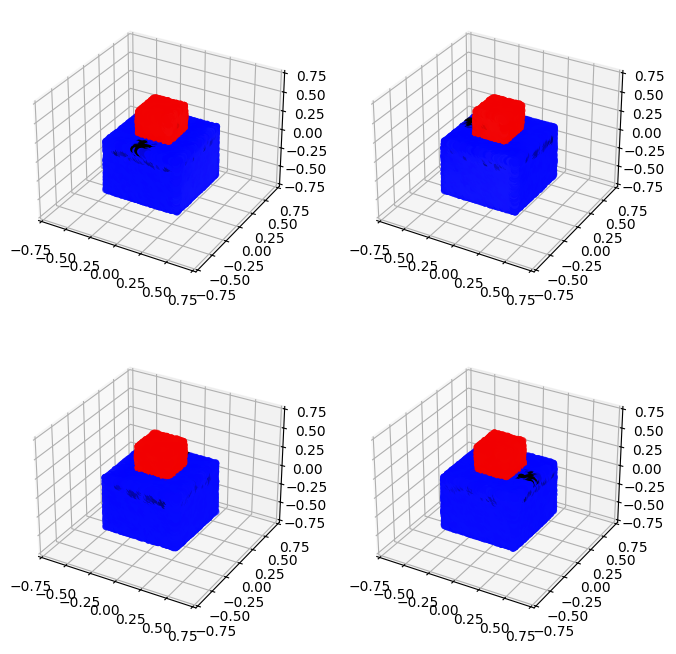

In [ ]:
final_pc = recursive_upsample(pc, num_recursive_steps)
fig = plot_point_cloud(
    final_pc,
    grid_size=2,
    fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75))
)